In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.datasets import load_sample_image

random_state = 42
tf.random.set_seed(random_state)

## Load Dataset

In [2]:
ann_path = "./caltech101_classification/res_"
images_path = "./caltech101_classification"

In [3]:
class_names = ["butterfly", "dalmatian", "dolphin"]
data = []
labels = []
bboxes = []
imagePaths = []

In [4]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

for cl in range(len(class_names)):
    ann_path_new = ann_path + class_names[cl] + ".txt"
    print(ann_path_new)
    rows = open(ann_path_new).read().strip().split("\n")
    
    # loop over the rows
    for idx, row in enumerate(rows):
        
        # break the row into the 
        # filename and bounding box coordinates
        row = row.split(",")
        
        filename = row[0]
        filename = filename.split(".")[0]
        filename = filename.split("_")[-1]
        filename = "image_" + filename + ".jpg"
        
        coords = row[1:]
        coords = [int(c) for c in coords]
        
        label = cl
        
        image_path = os.path.sep.join([images_path, class_names[cl], filename])
        
        image = cv2.imread(image_path)
        (h, w) = image.shape[:2]
        
        # scale the bounding box coordinates 
        # relative to the 
        # dimensions of the input image
        Xmin = float(coords[0]) / w
        Ymin = float(coords[1]) / h
        Xmax = float(coords[2]) / w
        Ymax = float(coords[3]) / h
        
        
        # load the image
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)

        
        data.append(image)
        labels.append(label)
        bboxes.append((Xmin, Ymin, Xmax, Ymax))
        imagePaths.append(image_path)

./caltech101_classification/res_butterfly.txt
./caltech101_classification/res_dalmatian.txt
./caltech101_classification/res_dolphin.txt


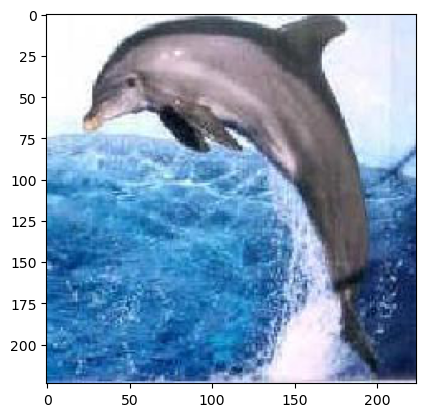

In [5]:
imgplot = plt.imshow(image.astype('uint8'))
plt.show()

In [6]:
# convert from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32")

# convert to numpy array
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

In [7]:
print(data.shape)
print(labels.shape)
print(bboxes.shape)

(195, 224, 224, 3)
(195,)
(195, 4)


In [8]:
from sklearn.model_selection import train_test_split
split_train_test = train_test_split(data, labels, bboxes, test_size=0.2, random_state=random_state)

In [9]:
(X_train_full, X_test) = split_train_test[:2]
(y_train_full, y_test) = split_train_test[2:4]
(bbox_train_full, bbox_test) = split_train_test[4:]

print(X_test.shape)

(39, 224, 224, 3)


In [10]:
bbox_train_full[:5]

array([[0.06666667, 0.18450184, 0.99666667, 0.9778598 ],
       [0.05666667, 0.13718411, 0.99666667, 0.6353791 ],
       [0.12      , 0.08536585, 0.93      , 0.99593496],
       [0.14333333, 0.05357143, 1.        , 0.75595236],
       [0.19      , 0.09947644, 0.66      , 1.        ]], dtype=float32)

In [11]:
split_train_valid = train_test_split(X_train_full, 
                                     y_train_full, 
                                     bbox_train_full, 
                                     test_size=0.1, 
                                     random_state=random_state)

In [12]:
(X_train, X_valid) = split_train_valid[:2]
(y_train, y_valid) = split_train_valid[2:4]
(bbox_train, bbox_valid) = split_train_valid[4:]

In [13]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)
print(bbox_train.shape)
print(bbox_valid.shape)

(140, 224, 224, 3)
(16, 224, 224, 3)
(140,)
(16,)
(140, 4)
(16, 4)


## Create the Model

In [14]:
X_train = keras.applications.resnet50.preprocess_input(X_train)
X_valid = keras.applications.resnet50.preprocess_input(X_valid)
X_test = keras.applications.resnet50.preprocess_input(X_test)

In [15]:
model_input = keras.Input(shape=(224, 224, 3))
base_model = keras.applications.resnet50.ResNet50(weights="imagenet", 
                                                  include_top=False,
                                                  input_shape=(224, 224, 3),
                                                  input_tensor=model_input)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

class_output = keras.layers.Dense(len(class_names), activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)

In [16]:
model = keras.Model(inputs=model_input, outputs=[class_output, loc_output])

In [17]:
for layer in base_model.layers:
    layer.trainable = True

## Compile the Model

In [18]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.0001)

/Users/desparza/miniconda3/envs/ml_env/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer)

In [20]:
history = model.fit(X_train, (y_train, bbox_train), epochs=20, validation_data=(X_valid, (y_valid, bbox_valid)))

Epoch 1/20


2023-04-16 10:09:49.738615: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 21s 4s/step - loss: 1.2764 - dense_loss: 1.1212 - dense_1_loss: 1.8971 - val_loss: 0.5692 - val_dense_loss: 0.4371 - val_dense_1_loss: 1.0976
Epoch 2/20
5/5 [==============================] - 18s 4s/step - loss: 0.4559 - dense_loss: 0.3946 - dense_1_loss: 0.7008 - val_loss: 0.2816 - val_dense_loss: 0.1621 - val_dense_1_loss: 0.7592
Epoch 3/20
5/5 [==============================] - 18s 3s/step - loss: 0.2434 - dense_loss: 0.1390 - dense_1_loss: 0.6610 - val_loss: 0.2489 - val_dense_loss: 0.0466 - val_dense_1_loss: 1.0584
Epoch 4/20
5/5 [==============================] - 18s 4s/step - loss: 0.1444 - dense_loss: 0.0385 - dense_1_loss: 0.5676 - val_loss: 0.1629 - val_dense_loss: 0.0198 - val_dense_1_loss: 0.7350
Epoch 5/20
5/5 [==============================] - 19s 4s/step - loss: 0.0717 - dense_loss: 0.0237 - dense_1_loss: 0.2634 - val_loss: 0.1727 - val_dense_loss: 0.0122 - val_dense_1_loss: 0.8144
Epoch 6/20
5/5 [==============================] - 1

In [21]:
model.evaluate(X_test, (y_test, bbox_test))

2/2 [==============================] - 1s 243ms/step - loss: 0.1084 - dense_loss: 0.0175 - dense_1_loss: 0.4720


[0.10836156457662582, 0.017451370134949684, 0.4720023274421692]

## Predictions

In [22]:
X_new = np.copy(X_train_full[:10, :, :, :])
y_new = np.copy(y_train_full[:10,])
bbox_new = np.copy(bbox_train_full[:10, :])

X_new.shape

(10, 224, 224, 3)

In [23]:
preds = model.predict(keras.applications.resnet50.preprocess_input(X_new))

1/1 [==============================] - 1s 726ms/step


In [24]:
preds[0].round(2)

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [25]:
y_pred = np.argmax(preds[0], axis=1)
y_pred

array([0, 2, 1, 2, 1, 0, 1, 0, 2, 0])

In [26]:
y_new

array([0, 2, 1, 2, 1, 0, 1, 0, 2, 0])

In [27]:
preds[1]

array([[-0.06377379,  0.54734015,  1.0036371 ,  0.7981873 ],
       [-0.03109777,  0.12087527,  1.2671471 ,  0.5425547 ],
       [-0.43561402,  0.10729762,  1.3106078 ,  0.9918704 ],
       [ 0.07895561,  0.39571592,  1.453605  ,  1.1601238 ],
       [ 0.2434429 ,  0.06354104,  0.53737473,  0.9724514 ],
       [ 0.00171211,  0.018058  ,  1.4795036 ,  1.3297442 ],
       [ 0.10344128, -0.46096185,  1.1587119 ,  1.5458333 ],
       [ 0.272041  ,  0.12653188,  1.1332989 ,  1.268422  ],
       [ 0.27286988, -0.01996876,  1.4435453 ,  0.6663174 ],
       [ 0.37100354,  0.81548065,  1.295496  ,  0.88648427]],
      dtype=float32)

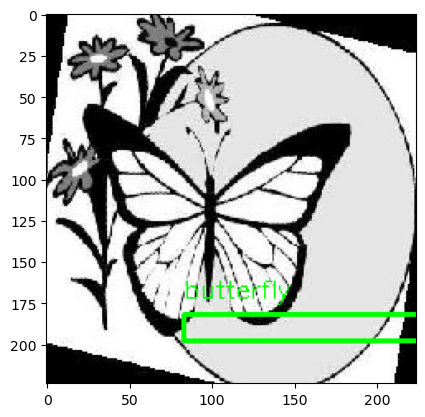

In [54]:
import matplotlib.patches as patches

img_idx = 9
startX, startY, endX, endY = preds[1][img_idx,:]
startX, startY, endX, endY

img = np.copy(X_train_full[img_idx,:,:,:])
(h, w) = img.shape[:2]

startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

y = startY - 10 if startY - 10 > 10 else startY + 10
label = class_names[y_pred[img_idx]]

cv2.putText(img, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)
imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))

plt.show()